In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [17]:
def get_factscore_info(factscores):
    num_true_all = []
    num_total_all = []
    frac_correct_facts = []
    for i in range(len(factscores["decisions"])):
        decison = factscores["decisions"][i]
        if decison == None:
            num_total_all.append(0)
            num_true_all.append(0)
            frac_correct_facts.append(0)
        else:
            num_total_all.append(len(decison))
            num_true_all.append(np.sum([fact["is_supported"] for fact in decison]))
            frac_correct_facts.append(np.sum([fact["is_supported"] for fact in decison])/len(decison))
    num_total_all = np.array(num_total_all)
    num_true_all = np.array(num_true_all)
    frac_correct_facts = np.array(frac_correct_facts)
    num_false_all = num_total_all - num_true_all
    return num_total_all, num_true_all, num_false_all, frac_correct_facts

def get_bin_mean(x_axis, y_axis, bins):
    x_axis = np.array(x_axis)
    y_axis = np.array(y_axis)
    bin_avgs = []
    for i in range(len(bins)-1):
        idxs = np.where((x_axis >= bins[i]) & (x_axis < bins[i+1]))[0]
        # print(len(idxs))
        bin_avgs.append(np.mean(y_axis[idxs]))
    return np.array(bin_avgs)

def get_bin_median(x_axis, y_axis, bins):
    x_axis = np.array(x_axis)
    y_axis = np.array(y_axis)
    bin_avgs = []
    for i in range(len(bins)-1):
        idxs = np.where((x_axis >= bins[i]) & (x_axis < bins[i+1]))[0]
        bin_avgs.append(np.median(y_axis[idxs]))
    return np.array(bin_avgs)

In [12]:
with open("base_model_few_shot_accuracy/wikibios/bios_base_model_samples_factscore.json", "rb") as f:
    base_model_factscore = json.load(f)

In [34]:
num_total_all, num_true_all, num_false_all, frac_correct_facts = get_factscore_info(base_model_factscore)

unfamiliarity_score = np.mean([num_false_all[:len(num_false_all)//2], num_false_all[len(num_false_all)//2:]], axis=0)
# unfamiliarity_score = np.mean([frac_correct_facts[:len(frac_correct_facts)//2], frac_correct_facts[len(frac_correct_facts)//2:]], axis=0)

In [35]:
bins = [0, 2, 4, 6, 8, 20]
# bins = [0, 0.2, 0.4, 0.6, 0.8, 1]

In [14]:
with open("ckpts/sft_bios_new_llama7B/checkpoint_20000/hf_model/factscores_test_medium.json") as f:
    factscores = json.load(f)

sft_num_total_all, sft_num_true_all, sft_num_false_all, sft_frac_correct_facts = get_factscore_info(factscores)

In [15]:
with open("ckpts/ppo_rm_bios_llama7B_true2_false-3_kl0pt5/checkpoint_017000/hf_model/factscores_test_medium.json", "r") as f:
    factscores = json.load(f)

ppo_num_total_all, ppo_num_true_all, ppo_num_false_all, ppo_frac_correct_facts = get_factscore_info(factscores)

In [16]:
with open("ckpts/ppo_rm_bios_llama7B_true2_false-3_kl0pt5_GPT3pt5/checkpoint_006000/hf_model/factscores_test_medium.json", "r") as f:
    factscores = json.load(f)

ppo_num_total_all2, ppo_num_true_all2, ppo_num_false_all2, ppo_frac_correct_facts2 = get_factscore_info(factscores)

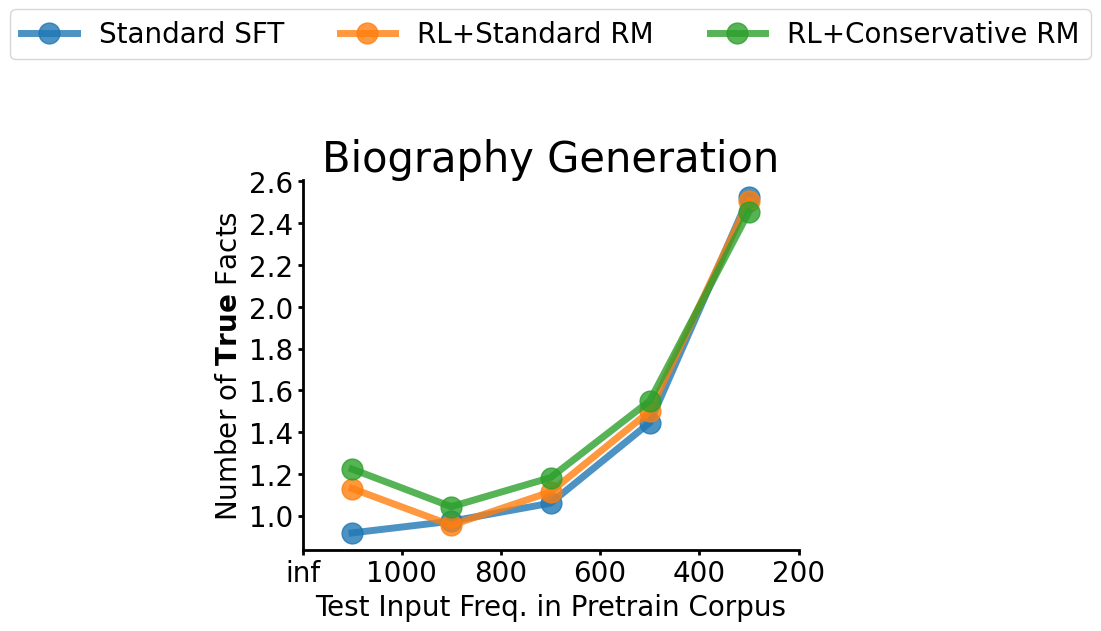

In [29]:
x= np.arange(0, len(bins)-1, 1)

sft_bin_avgs = np.flip(get_bin_mean(unfamiliarity_score, sft_num_true_all, bins))
ppo_bin_avgs = np.flip(get_bin_mean(unfamiliarity_score, ppo_num_true_all, bins))
ppo_bin_avgs2 = np.flip(get_bin_mean(unfamiliarity_score, ppo_num_true_all2, bins))
plt.plot(x, sft_bin_avgs, "o-", label="Standard SFT", markersize=15, linewidth=5, alpha=0.8)
plt.plot(x, ppo_bin_avgs2, "o-",label="RL+Standard RM", markersize=15, linewidth=5, alpha=0.8)
plt.plot(x, ppo_bin_avgs, "o-",label="RL+Conservative RM", markersize=15, linewidth=5, alpha=0.8)


# plt.ylim(0, 3.5)

plt.yticks(fontsize=20)
plt.xlabel("Test Input Freq. in Pretrain Corpus", fontsize=20)
plt.ylabel("Number of $\mathbf{True}$ Facts", fontsize=20)
plt.xticks(np.append(x,len(bins)-1 )-0.5, ["inf", 1000, 800, 600, 400, 200], fontsize=20)

#make spines thicker
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', width=2)

#remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Biography Generation", fontsize=30)

# add legend to top
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5), ncol=3, fontsize=20)

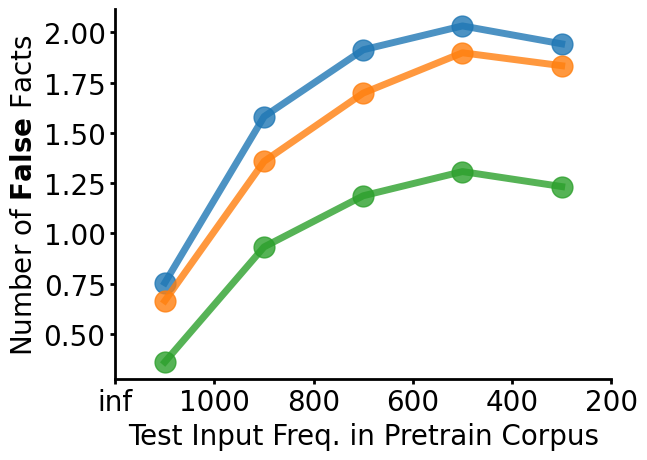

In [36]:
x= np.arange(0, len(bins)-1, 1)

sft_bin_avgs = (get_bin_mean(unfamiliarity_score, sft_num_false_all, bins))
ppo_bin_avgs = (get_bin_mean(unfamiliarity_score, ppo_num_false_all, bins))
ppo_bin_avgs2 = (get_bin_mean(unfamiliarity_score, ppo_num_false_all2, bins))
plt.plot(x, sft_bin_avgs, "o-", label="SFT", markersize=15, linewidth=5, alpha=0.8)
plt.plot(x, ppo_bin_avgs2, "o-",label="RL w/ GPT3.5 RM", markersize=15, linewidth=5, alpha=0.8)
plt.plot(x, ppo_bin_avgs, "o-",label="RL w/ llama2 7B RM", markersize=15, linewidth=5, alpha=0.8)


# plt.ylim(0, 1.5)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Number of $\mathbf{False}$ Facts", fontsize=20)
plt.xlabel("Test Input Freq. in Pretrain Corpus", fontsize=20)
plt.xticks(np.append(x,len(bins)-1 )-0.5, ["inf", 1000, 800, 600, 400, 200], fontsize=20)

#make spines thicker
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', width=2)

#remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title("Biography Generation", fontsize=20)

In [37]:
with open("ckpts/sft_bios_new_llama7B/checkpoint_20000/hf_model/factscores_test_medium.json", "r") as f:
    factscores = json.load(f)

decisions = factscores["decisions"]

lines_all = []
correct_all = []
bio_idxs = []
for i, decision in enumerate(decisions):
    if decision is not None: 
        for atomic_fact in decision:
            lines_all.append(atomic_fact["atom"])
            correct_all.append(atomic_fact["is_supported"])
            bio_idxs.append(i)
    else:
        print("here")
lines_all = np.array(lines_all)
correct_all = np.array(correct_all)
bio_idxs = np.array(bio_idxs)
true_samples = np.where(correct_all == True)[0]
false_samples = np.where(correct_all == False)[0]

In [38]:
rm_path = "ckpts/rm2_atmoic_facts_llama7B/checkpoint_10000/hf_model/"
rm_gpt3pt5_path = "ckpts/rm2_atmoic_facts_gpt3pt5_llama7B/checkpoint_10000/hf_model/" 


rm_samples_preds = np.load(rm_path + "test_medium_samples_preds.npy")
rm_samples_preds = (rm_samples_preds == " Yes.")
rm_gpt3pt5_samples_preds = np.load(rm_gpt3pt5_path + "test_medium_samples_preds.npy")
rm_gpt3pt5_samples_preds = (rm_gpt3pt5_samples_preds == " Yes.")

In [39]:
real_rewards = []
rm_rewards = []
rm_gpt3pt5_rewards = []

for i in range(len(decisions)):
    if decisions[i] is not None:
        fact_idxs = np.where(bio_idxs == i)[0]

        num_true = correct_all[fact_idxs].sum()
        num_false = len(fact_idxs) - num_true
        real_rewards.append(2*num_true - 3*num_false)


        num_true = rm_samples_preds[fact_idxs].sum()
        num_false = len(fact_idxs) - num_true
        rm_rewards.append(2*num_true - 3*num_false)

        num_true = rm_gpt3pt5_samples_preds[fact_idxs].sum()
        num_false = len(fact_idxs) - num_true
        rm_gpt3pt5_rewards.append(2*num_true - 3*num_false)

In [40]:
real_rewards = np.array(real_rewards)
rm_rewards = np.array(rm_rewards)
rm_gpt3pt5_rewards = np.array(rm_gpt3pt5_rewards)

/tmp/ipykernel_30730/1370684865.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x,  np.array(binned_real_rewards), "o-", label="Ground Truth", markersize=15, linewidth=5, linestyle="--", color="black", alpha=0.8)


Text(0.5, 1.0, 'Biography Generation')

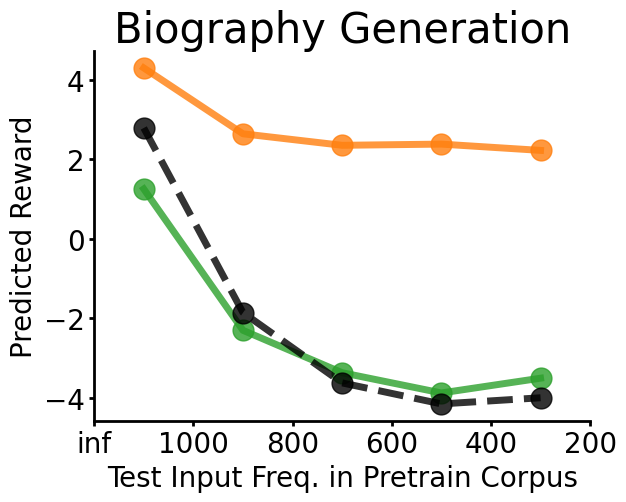

In [42]:
x = np.arange(len(bins)-1)


binned_rm_rewards = (get_bin_mean(unfamiliarity_score, rm_rewards, bins))
plt.plot(x,  np.array(binned_rm_rewards), "o-", label="llama2 7B RM", markersize=15, linewidth=5, alpha=0.8, color="C2")

binned_rm_gpt3pt5_rewards = (get_bin_mean(unfamiliarity_score, rm_gpt3pt5_rewards, bins))
plt.plot(x,  np.array(binned_rm_gpt3pt5_rewards), "o-", label="GPT3.5 RM", markersize=15, linewidth=5, alpha=0.8,  color="C1")

binned_real_rewards = (get_bin_mean(unfamiliarity_score, real_rewards, bins))
plt.plot(x,  np.array(binned_real_rewards), "o-", label="Ground Truth", markersize=15, linewidth=5, linestyle="--", color="black", alpha=0.8)

# plt.legend()

plt.xticks(np.append(x, len(bins)-1)-0.5, ["inf", "1000", "800", "600", "400", "200"], fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("Test Input Freq. in Pretrain Corpus", fontsize=20)
plt.ylabel("Predicted Reward", fontsize=20)

#make spines thicker
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', width=2)

#remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.legend(fontsize=20)
# plt.ylim(-7, 10)

plt.title("Biography Generation", fontsize=30)